# set things up and get the data

In [49]:
%%time
from Startup import *
from matplotlib import pyplot as plt
import numpy as np
import scipy
# from scipy.stats import zscore

%matplotlib inline
# df = sqlContext.sql("SELECT * FROM parquet.`s3://philipp-ghcnd/GHCND_WT08_1960_2020_US.parquet`")

query =""" SELECT * FROM parquet.`/mnt/d/02_acads/3.SP-20/dsc291/Public-DSC291/Data/GHCND_WT08_1960_2020_US.parquet/` 
WHERE year >= 2006
"""
df = sqlContext.sql(query)
pdf = df.toPandas()

CPU times: user 109 ms, sys: 31.2 ms, total: 141 ms
Wall time: 1.63 s


## I exported the dataframe in string data type because that's the only thing that worked, so convert back...

In [53]:
print(pdf.head())
# pdf.iloc[100:104]
print(pdf.describe())
# len(list(pdf.iloc[1]['Values'].split(',')))
# pdf.iloc[1]['Values']

       Station  year                                             Values
0  USW00014735  2006  [1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...
1  USW00014735  2007  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2  USW00014735  2008  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
3  USW00014735  2009  [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...
4  USW00014735  2010  [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
            Station   year                                             Values
count         12950  12950                                              12950
unique          937     15                                              12746
top     USW00003959   2012  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
freq             15    910                                                 16


In [3]:
%%time
from ast import literal_eval
pdf['Values'] = pdf['Values'].apply(literal_eval) # think I saved it as string

CPU times: user 28.3 s, sys: 719 ms, total: 29.1 s
Wall time: 31.6 s


In [54]:
print(pdf.head())

wt08_graphs=[]
for i in range(pdf.shape[0]):
    wt08_graphs.append(pdf.iloc[i,2])
wt08_graphs=np.stack(wt08_graphs)

print(wt08_graphs.shape)

       Station  year                                             Values
0  USW00014735  2006  [1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...
1  USW00014735  2007  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2  USW00014735  2008  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
3  USW00014735  2009  [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...
4  USW00014735  2010  [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
(12950,)


## compute num of stations by year  and Mean number of days smog was reported

In [59]:
years = np.unique(pdf['year'])
print(years)

['2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015'
 '2016' '2017' '2018' '2019' '2020']


In [60]:
%%time
wt08_count_byyear =[]
num_stations_byyear= []
for year in years:
    wt08_count_thisyear = []
    station_count_thisyear = 0
    for i in range(wt08_graphs.shape[0]):
        if pdf['year'][i] == year:
            station_count_thisyear +=1
            wt08_count_thisyear.append(np.sum(wt08_graphs[i,:]))
    wt08_count_byyear.append(np.mean(wt08_count_thisyear))
    num_stations_byyear.append(station_count_thisyear)

IndexError: too many indices for array

In [7]:
# print(wt08_count_byyear)
print(np.sum(num_stations_byyear)) # for verification

32295


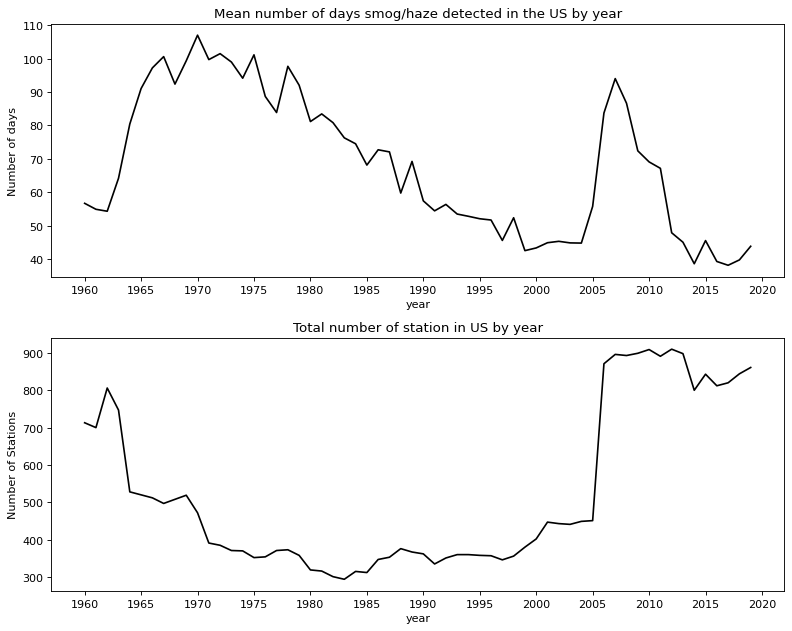

In [43]:
fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(211)
years = map(lambda x: int(x), years)
years = list(years)
ax1.plot(years[:-1],wt08_count_byyear[:-1],color='black',linestyle='-')
ax1.set_title('Mean number of days smog/haze detected in the US by year')
ax1.set_ylabel('Number of days')
ax1.set_xlabel('year')
plt.xticks(np.arange(min(years), max(years)+1, 5.0))
# fig.autofmt_xdate()

ax2 = plt.subplot(212)
# ax1 = fig1.add_axes([0,1,1,1])
ax2.plot(years[:-1],num_stations_byyear[:-1],color='black',linestyle='-')
ax2.set_title('Total number of station in US by year')
ax2.set_ylabel('Number of Stations')
ax2.set_xlabel('year')
plt.xticks(np.arange(min(years), max(years)+1, 5.0))
plt.tight_layout() 

The spike in 2005 is correlated to sudden increase in number of stations. My hypothesis is that most of these new stations are were located in smog area. Maybe?
However it does not explain the drop after 2012.

## compute means by year

In [9]:
%%time
wt08_byyear=[]
wt08_yearmean = []
years = np.unique(pdf['year'])
for year in years:
    wt08_thisyear = []
    for i in range(wt08_graphs.shape[0]):
        if pdf['year'][i] == year:
            wt08_thisyear.append(wt08_graphs[i,:])
    wt08_byyear.append(np.mean(wt08_thisyear, axis=0))
    wt08_yearmean.append(np.mean(wt08_thisyear))
wt08_byyear=np.stack(wt08_byyear)

print(wt08_byyear.shape)

(61, 365)
CPU times: user 1min 11s, sys: 375 ms, total: 1min 12s
Wall time: 1min 17s


## plot overall mean by year 

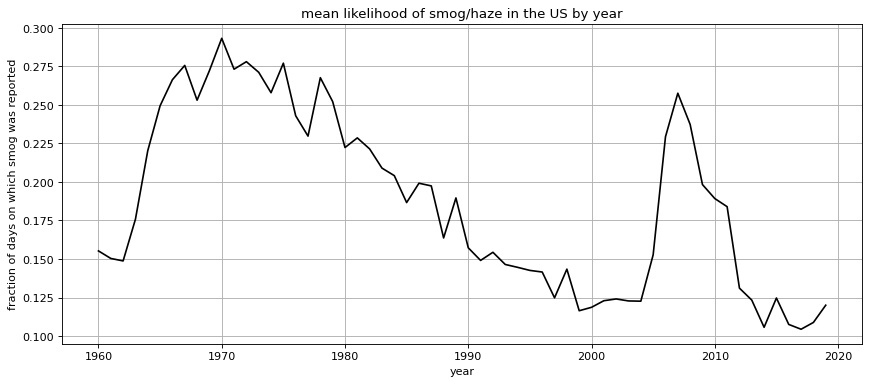

In [45]:
fig1 = plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig1.add_axes([0,0,1,1])
ax1.plot(years[:-1],wt08_yearmean[:-1],color='black',linestyle='-')
ax1.set_title('mean likelihood of smog/haze in the US by year')
ax1.set_ylabel('fraction of days on which smog was reported')
ax1.set_xlabel('year')
ax1.grid()

## plot by day

In [11]:
wt08_byyear_mean = np.mean(wt08_byyear[:-1,:], axis=0)
wt08_byyear_std = np.std(wt08_byyear[:-1,:], axis=0)

In [12]:
from matplotlib import cm
colmap = cm.get_cmap('jet', len(years)-1)
colors = colmap(range(len(years)-1))

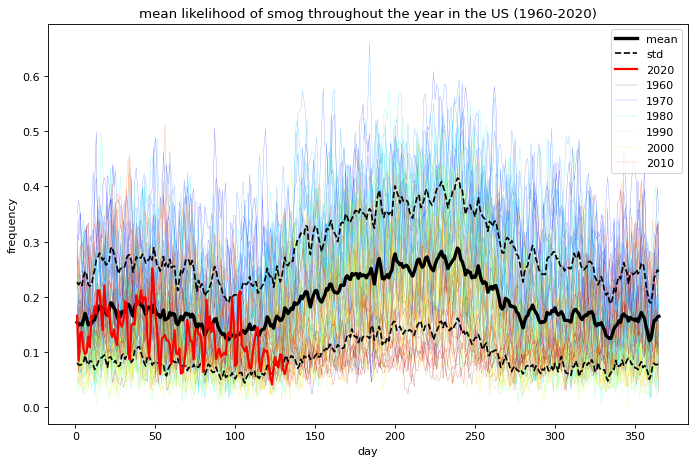

In [13]:
fig2 = plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax2 = fig2.add_axes([0,0,1,1])
theLines = []
for i in range(len(years)-1):
    yrplot, = ax2.plot(np.arange(1,366),wt08_byyear[i,:],color=colors[i,:3],alpha=0.5,lw=0.3,label=str(years[i]))
    if int(years[i]) % 10 == 0:
        theLines.append(yrplot)
stdplot, = ax2.plot(np.arange(1,366),wt08_byyear_mean+wt08_byyear_std,color='black',linestyle='--',label='std')
ax2.plot(np.arange(1,366),wt08_byyear_mean-wt08_byyear_std,color='black',linestyle='--')
meanplot, = ax2.plot(np.arange(1,366),wt08_byyear_mean,color='black',lw=3,label='mean')
mean2020, = ax2.plot(np.arange(1,134),wt08_byyear[-1,:133],color='red',alpha=1,lw=2,label='2020')
ax2.set_title('mean likelihood of smog throughout the year in the US (1960-2020)')
ax2.set_ylabel('frequency')
ax2.set_xlabel('day')
allLines = [meanplot, stdplot, mean2020]
for i in range(len(theLines)):
    allLines.append(theLines[i])
ax2.legend(handles=allLines)

# Z-test

In [14]:
wt08_2020 = wt08_byyear[-1,:133]
wt08_2020.shape
wt08_byyear_mean.shape
wt08_byyear_std.shape

z_scores = ( wt08_2020 - wt08_byyear_mean[:len(wt08_2020)] ) / wt08_byyear_std[:len(wt08_2020)] 

In [15]:
z_scores.shape

(133,)

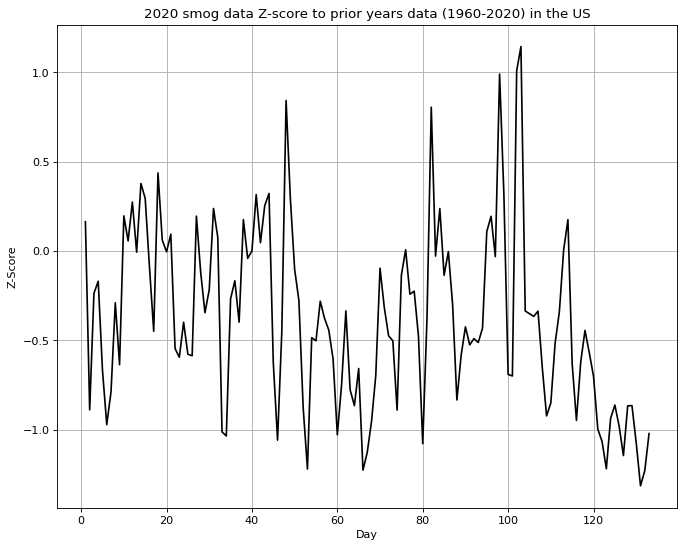

In [18]:
fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
days = np.arange(1,len(z_scores)+1, 1)
ax.plot(days,z_scores,color='black',linestyle='-')
ax.set_title('2020 smog data Z-score to prior years data (1960-2020) in the US')
ax.set_ylabel('Z-Score')
ax.set_xlabel('Day')
ax.grid()
# ax.set_xticks(np.arange(min(days), max(days)+1, 5.0))

In [31]:
p_values = scipy.stats.norm.sf(abs(z_scores)) #one-sided

# p_values = scipy.stats.norm.sf(abs(z_scores))*2 #twosided

mean_p_value = np.mean(p_values)
print(mean_p_value)

0.31178181222503454


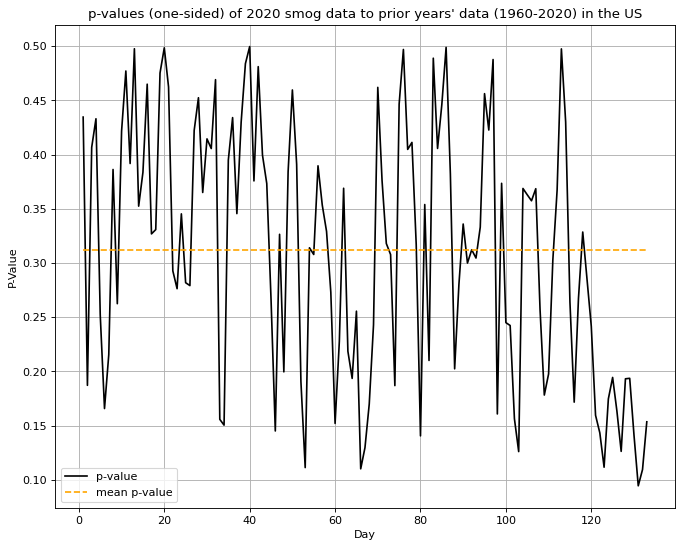

In [37]:
fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
days = np.arange(1,len(p_values)+1, 1)
ax.plot(days,p_values,color='black',linestyle='-',label="p-value")
ax.plot(days,[mean_p_value]*len(days),color='orange',linestyle='--',label="mean p-value")
ax.set_title('p-values (one-sided) of 2020 smog data to prior years\' data (1960-2020) in the US')
ax.set_ylabel('P-Value')
ax.set_xlabel('Day')
ax.grid()
ax.legend()
# ax.set_xticks(np.arange(min(days), max(days)+1, 5.0))